# Read data

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import spacy
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import word_tokenize
import warnings
warnings.filterwarnings('ignore')

sns.set()
%matplotlib inline

In [2]:
df = pd.read_csv('obama_speech_preprocessed.csv')

In [3]:
df_lda = df.drop(columns=['processed_for_sentiment'])

In [4]:
en = spacy.load('en_core_web_lg')
stopwords = en.Defaults.stop_words
Stop_Words = list(stopwords)
Stop_Words.extend(["u", "from", 'obama', 'barack', 'america', 'transcription', 'bankmovie', 'rhetoricbarackobama', 'andas', 'today',
     'everyday', 'everybody', 'speechesonline', 'copyright', 'audit', 'debatethird','video)barackobamaremark','transcript',
     'mp3','pdf','CD','Book','american', 'president', 'country',
     'year', 'day', 'thank','way','thing','get','something','everything','nation','world','let','state','idea','try',
     'part','place','time','fact','talk','look','kind','problem','end','progress','program','use','example','face','point','challenge',
                  'history','meet','make','month','decade','member','start','step','see','cut','office','use','point','term','number','question',
              'government','greet','meantime','god','americans','mr.','evening','afternoon','morning'])
# Remove stopword
def stop(x):
    t = word_tokenize(x)
    tok = [word for word in t if not word in Stop_Words]
    d = " ".join(tok)
    return d

In [5]:
df_lda['doc_lda'] = df_lda['processed_for_lda'].apply(lambda x: stop(x))

In [6]:
def freq_filter(x):
    words: list[str] = nltk.word_tokenize(x)
    fd = nltk.FreqDist(words)
    cc = []
    for i in words:
        if fd.freq(i) < 5:
             cc.append(i)
    fil = " ".join(cc)
    return fil

In [7]:
df_lda['doc_filter'] = df_lda['doc_lda'].apply(lambda x: freq_filter(x))

# LDA

In [8]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [9]:
corpus = df_lda['doc_filter']

In [10]:
vectorizer = CountVectorizer(min_df=5, max_df=0.9, stop_words='english')
tf_matrix = vectorizer.fit_transform(corpus)
tf_feature_names = vectorizer.get_feature_names_out()

## Perplexity

In [12]:
plexs = []
number_topic = list(range(2,20))
for i in number_topic:
    lda = LatentDirichletAllocation(n_components=i, max_iter=20,
                                    learning_method='online',
                                    random_state=0)
    lda.fit(tf_matrix)
    plexs.append(lda.perplexity(tf_matrix))

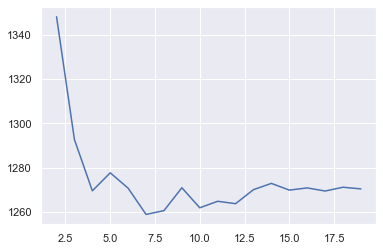

In [15]:
x_axis = number_topic
plt.plot(x_axis, plexs)
plt.show()

# Training a model

In [16]:
## Determine the number of topic corresponding to the lowest value of perplexity
plex = pd.DataFrame(list(zip(number_topic,plexs)), columns=['topic number','perplexity'])
plex.sort_values("perplexity",inplace=True)
num_topic = plex.iloc[0,0]

In [17]:
lda = LatentDirichletAllocation(learning_method='online', n_components=num_topic, random_state=0, learning_decay=0.5)
lda.fit(tf_matrix)
num_top_words = 20

In [18]:
lda_components = lda.components_
topic_top_words = []
for index, component in enumerate(lda_components):
    zipped = zip(tf_feature_names, component)
    top_key = sorted(zipped, key = lambda t: t[1], reverse=True)[:num_top_words]
    top_terms_list = list(dict(top_key).keys())
    print("Topic "+str(index)+": ",top_terms_list)
    topic_top_words.append(top_terms_list)

Topic 0:  ['job', 'business', 'economy', 'need', 'tax', 'pay', 'company', 'energy', 'help', 'deficit', 'plan', 'family', 'care', 'governor', 'create', 'reform', 'health', 'worker', 'college', 'cost']
Topic 1:  ['health', 'care', 'insurance', 'think', 'lot', 'help', 'need', 'folk', 'family', 'law', 'cost', 'happen', 'pay', 'like', 'money', 'school', 'kid', 'tell', 'mean', 'provide']
Topic 2:  ['life', 'man', 'woman', 'family', 'child', 'democracy', 'change', 'help', 'love', 'united', 'believe', 'states', 'need', 'war', 'faith', 'generation', 'stand', 'freedom', 'tell', 'power']
Topic 3:  ['iraq', 'force', 'war', 'troop', 'afghanistan', 'support', 'isil', 'security', 'fight', 'syria', 'ally', 'serve', 'continue', 'united', 'effort', 'threat', 'mission', 'attack', 'include', 'partner']
Topic 4:  ['united', 'states', 'iran', 'security', 'continue', 'think', 'region', 'russia', 'deal', 'weapon', 'israel', 'peace', 'china', 'issue', 'cooperation', 'include', 'support', 'sanction', 'asia', 'b

In [19]:
# Load topic distribution
doc_topic_dist = lda.transform(tf_matrix).tolist()

In [20]:
df_lda['topic_distributions'] = pd.Series(doc_topic_dist)
topic_distributions_df = df_lda['topic_distributions'].apply(pd.Series)

In [21]:
topic_distributions_df.columns = [" ".join(topic[:5]) for topic in topic_top_words]
#Merge that column into the dataframe
df_lda_for_plot = pd.concat([df_lda, topic_distributions_df], axis=1)

# Visualization

Visualizing LDA using pyLDSvis. The result is plotted in the html file named by lda_"num_topic", for example, lda_7.html

In [23]:
import pyLDAvis.sklearn

In [26]:
pyLDAvis.enable_notebook()
dash = pyLDAvis.sklearn.prepare(lda, tf_matrix, vectorizer)
pyLDAvis.save_html(dash, 'lda_'+str(num_topic)+'.html')

Make plots of topic distribution for speeches from 2009 to 2017

In [27]:
# Convert to datetime
df_lda_for_plot['date'] = pd.to_datetime(df_lda_for_plot['date'])
# Extract year
df_lda_for_plot['year'] = pd.to_datetime(df_lda_for_plot['date'].dt.year, format='%Y')
# Extract year and month
df_lda_for_plot['year-month'] = df_lda_for_plot['date'].dt.to_period('M')
df_lda_for_plot['Date (by month)'] = [month.to_timestamp() for month in df_lda_for_plot['year-month']]
# Set year and month as Pandas Index
df_lda_for_plot = df_lda_for_plot.set_index('Date (by month)')

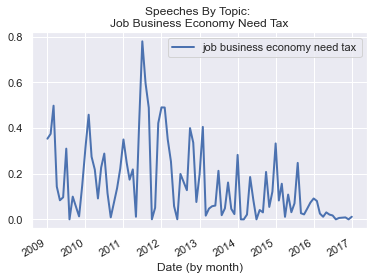

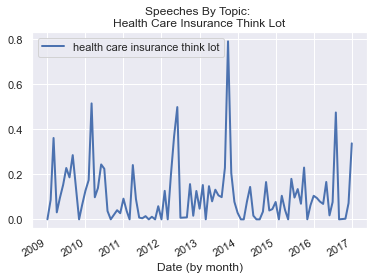

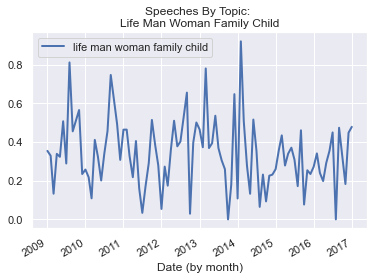

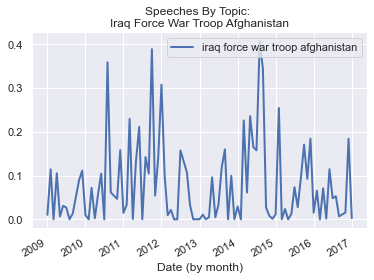

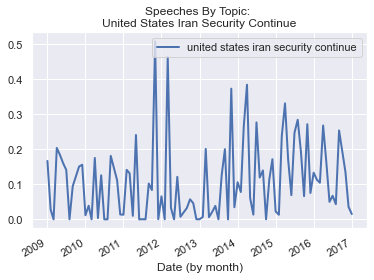

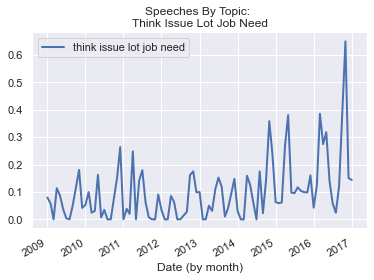

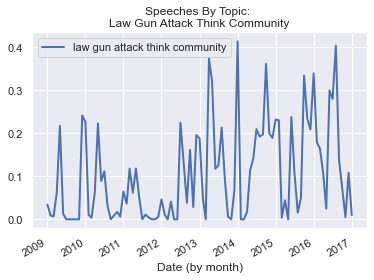

In [28]:
topic_num_range = list(range(num_topic))
for i in topic_num_range:
     topic_number = i
     topic_label = " ".join(topic_top_words[i][:5])
     df_lda_for_plot.groupby(df_lda_for_plot.index)[[topic_label]].mean().plot(title=f'Speeches By Topic: \n{topic_label.title()}', linewidth=2)